# Lab 2 #
## The Dijkstra’s Algorithm ##

We shall create a graph for this project and create helper functions 

In [151]:
G = {
    "A": [("B", 2), ("D", 4), ("E", 7)],
    "B": [("C", 3), ("E", 1), ("F", 4)],
    "C": [("F", 2)],
    "D": [("E", 5)],
    "E": [("F", 6)],
    "F": []
}


def get_neighbours(graph, v): #get the neighbour of vertex v from the graph
    return graph[v]


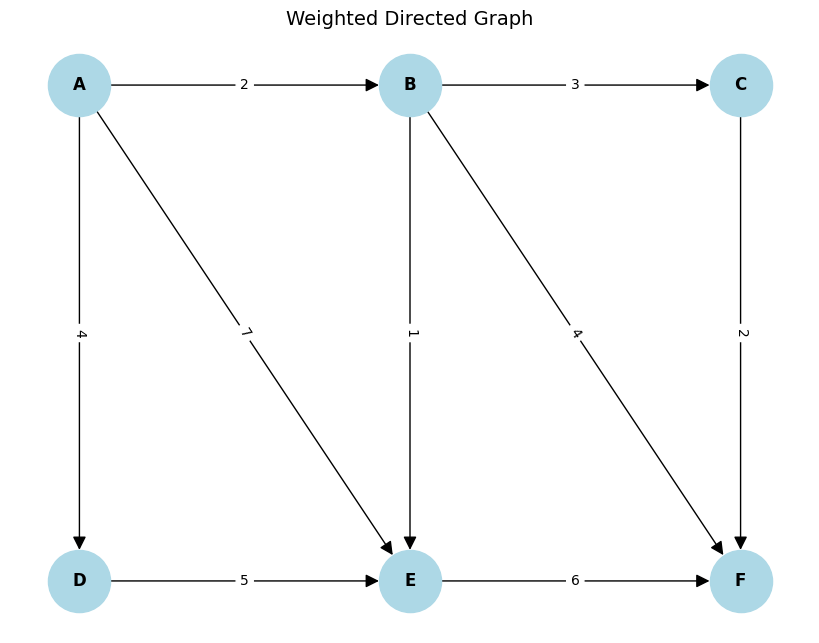

In [152]:
import matplotlib.pyplot as plt
import networkx as nx

Graph = nx.DiGraph()

# Add edges with weights
for u, neighbors in G.items():
    for v, w in neighbors:
        Graph.add_edge(u, v, weight=w)

pos = {
    "A": (0, 2),
    "B": (2, 2),
    "C": (4, 2),
    "D": (0, 0),
    "E": (2, 0),
    "F": (4, 0),
}

plt.figure(figsize=(8, 6))

# Draw nodes and edges
nx.draw(Graph, pos, with_labels=True, node_size=2000, node_color="lightblue",
        font_size=12, font_weight="bold", arrowsize=20)
nx.draw_networkx_edge_labels(Graph, pos, edge_labels=nx.get_edge_attributes(Graph, "weight"), font_size=10)

plt.title("Weighted Directed Graph", fontsize=14)
plt.axis("off")
plt.show()

## Part 1: Using an array for the priority queue ##

In [153]:
def dijkstra_using_array(graph, start):
    d={node : float("inf") for node in graph.keys()} #to store the shortest distance from source to each node
    pi = {node :None for node in graph.keys()} # to hold the predecessor of each node
    visited = set() # to hold the visited nodes
    unvisited = set(graph.keys())
    d[start] = 0
    while unvisited:
        current = min(unvisited, key= lambda node: d[node]) #using an array 
        unvisited.remove(current) # i have visited this node
        visited.add(current)
        for neighbour, weight in get_neighbours(graph, current):
            if neighbour not in visited:
                if d[current] + weight < d[neighbour]:
                    d[neighbour] = d[current] + weight
                    pi[neighbour] = current
    return d, pi, visited

In [154]:
dijkstra_using_array(G, "A")

({'A': 0, 'B': 2, 'C': 5, 'D': 4, 'E': 3, 'F': 6},
 {'A': None, 'B': 'A', 'C': 'B', 'D': 'A', 'E': 'B', 'F': 'B'},
 {'A', 'B', 'C', 'D', 'E', 'F'})

In [155]:
import random, time
from collections import defaultdict

time_taken_result = []
input_sizes = [20, 50, 100, 200, 500, 1000, 2000, 5000]

def generate_matrix(V, edge_prob=0.3, max_weight=10): #v is the number of vertices
    num_of_edge = 0
    graph = defaultdict(list)
    for i in range(V):
        for j in range(V):
            if i != j and random.random() > edge_prob: #70% chance of creating edges
                graph[i].append((j, random.randint(1, max_weight)))
                num_of_edge += 1
    return graph, num_of_edge

for V in input_sizes:
    Graph, edge_count = generate_matrix(V)
    start = time.time()
    dijkstra_using_array(Graph, 0)
    end = time.time()
    time_taken = end - start
    time_taken_result.append(((V,edge_count), f"{time_taken:.8f}"))



In [156]:
time_taken_result

[((20, 269), '0.00000000'),
 ((50, 1715), '0.00100207'),
 ((100, 7064), '0.00200033'),
 ((200, 27981), '0.00700068'),
 ((500, 174505), '0.04055643'),
 ((1000, 699145), '0.15396547'),
 ((2000, 2798043), '0.70994329'),
 ((5000, 17496170), '6.31665802')]

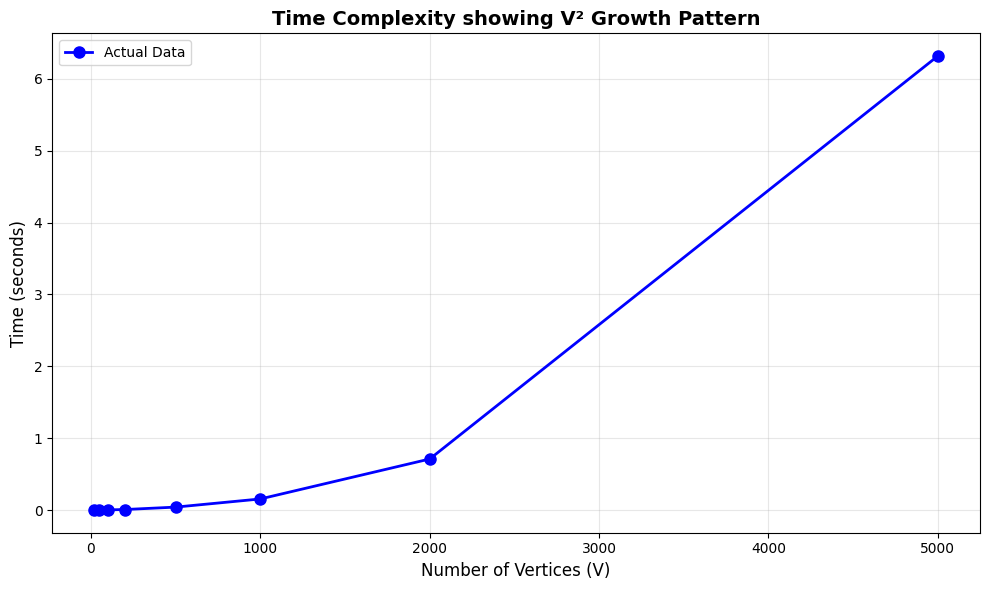

In [ ]:
import matplotlib.pyplot as plt
# Data
V_values = [item[0][0] for item in time_taken_result]
time_values = [float(item[1]) for item in time_taken_result]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(V_values, time_values, 'b-o', linewidth=2, markersize=8, label='Actual Data')
plt.xlabel('Number of Vertices (V)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Time Complexity showing V² Growth Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()